In [1]:
import os

In [2]:
base_path = "flofrumush"

In [3]:
train_dir = base_path + "/train"
valid_dir = base_path + "/valid"
test_dir = base_path + "/test"

In [4]:
flower_train = os.listdir(train_dir + "/flower")
fruit_train = os.listdir(train_dir + "/fruit")
mush_train = os.listdir(train_dir + "/mushroom")

In [5]:
flower_valid = os.listdir(valid_dir + "/flower")
fruit_valid = os.listdir(valid_dir + "/fruit")
mush_valid = os.listdir(valid_dir + "/mushroom")

In [6]:
flower_test = os.listdir(test_dir + "/flower")
fruit_test = os.listdir(test_dir + "/fruit")
mush_test = os.listdir(test_dir + "/mushroom")

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

2023-05-07 04:17:51.617876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import numpy as np

In [9]:
batch_size = 12
img_height = 256
img_width = 256

In [10]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, labels="inferred",image_size=(img_height, img_width),batch_size=batch_size)
val_data = tf.keras.utils.image_dataset_from_directory(valid_dir, labels="inferred",image_size=(img_height, img_width),batch_size=batch_size)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, labels="inferred",image_size=(img_height, img_width))

Found 458 files belonging to 3 classes.
Found 129 files belonging to 3 classes.
Found 67 files belonging to 3 classes.


In [11]:
class_names = train_data.class_names
print(class_names)

['flower', 'fruit', 'mushroom']


2023-05-07 04:17:55.054691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [458]
	 [[{{node Placeholder/_4}}]]
2023-05-07 04:17:55.055059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [458]
	 [[{{node Placeholder/_0}}]]


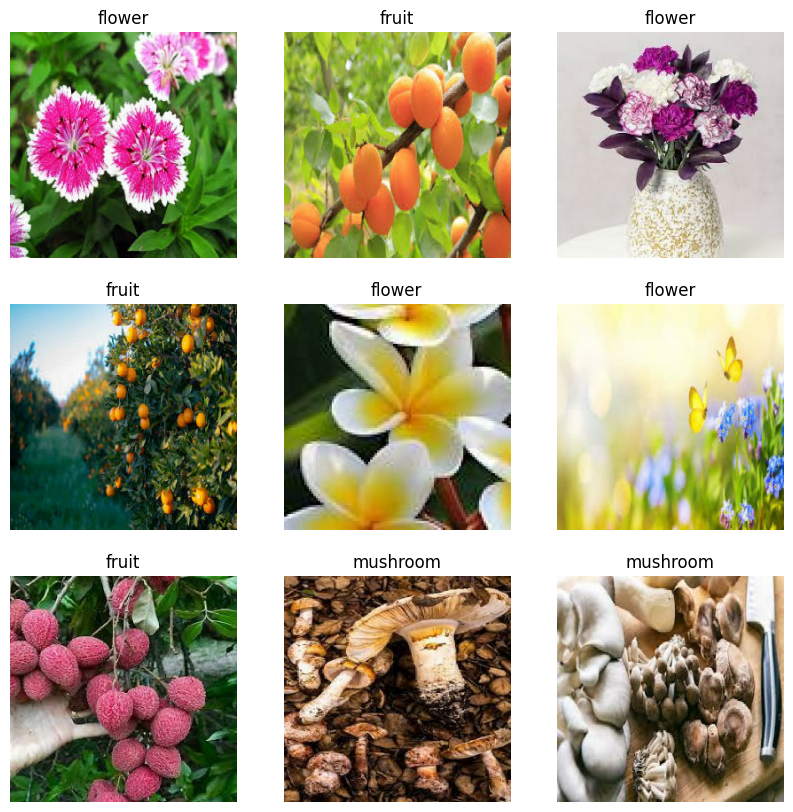

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in test_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


2023-05-07 04:17:56.354715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [67]
	 [[{{node Placeholder/_4}}]]
2023-05-07 04:17:56.355049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [67]
	 [[{{node Placeholder/_4}}]]


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

#train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
#val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
#test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


2023-05-07 04:17:56.573270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [458]
	 [[{{node Placeholder/_4}}]]
2023-05-07 04:17:56.573597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [458]
	 [[{{node Placeholder/_0}}]]


In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.5),
  ]
)

In [18]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath="models/",
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs=20
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/20


2023-05-07 04:17:57.240860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [458]
	 [[{{node Placeholder/_4}}]]
2023-05-07 04:17:57.241189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [458]
	 [[{{node Placeholder/_4}}]]


39/39 [==============================] - ETA: 0s - loss: 1.4112 - accuracy: 0.4214

2023-05-07 04:18:11.060091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [129]
	 [[{{node Placeholder/_4}}]]
2023-05-07 04:18:11.060608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [129]
	 [[{{node Placeholder/_0}}]]



Epoch 1: saving model to models/
39/39 [==============================] - 15s 343ms/step - loss: 1.4112 - accuracy: 0.4214 - val_loss: 0.9153 - val_accuracy: 0.5581
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 0.8306 - accuracy: 0.6528
Epoch 2: saving model to models/
39/39 [==============================] - 13s 342ms/step - loss: 0.8306 - accuracy: 0.6528 - val_loss: 0.7491 - val_accuracy: 0.7132
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7314
Epoch 3: saving model to models/
39/39 [==============================] - 14s 345ms/step - loss: 0.6526 - accuracy: 0.7314 - val_loss: 1.2686 - val_accuracy: 0.5659
Epoch 4/20
39/39 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7424
Epoch 4: saving model to models/
39/39 [==============================] - 14s 348ms/step - loss: 0.6511 - accuracy: 0.7424 - val_loss: 0.7927 - val_accuracy: 0.7132
Epoch 5/20
39/39 [==============================] - ETA: 

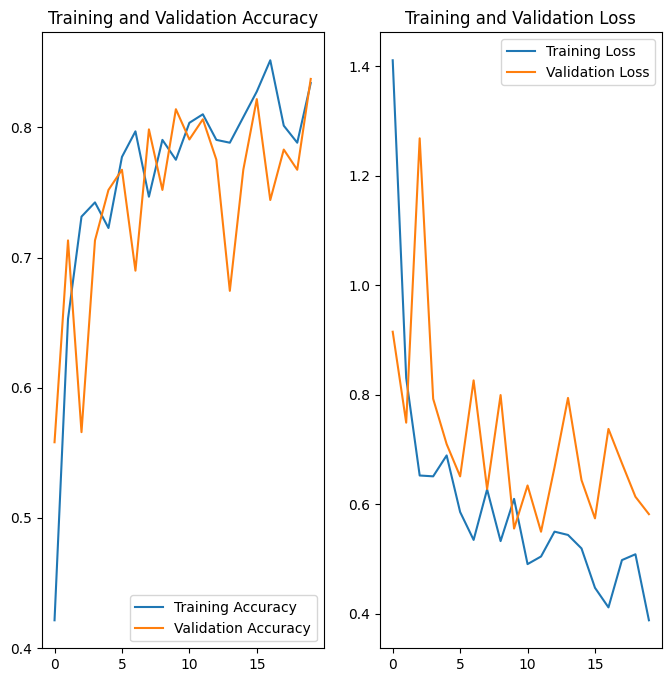

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('traning_val_acc_loss.png')
plt.show()

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [24]:
results = model.evaluate(test_data)
print("test loss:", results[0], "test acc:", results[1])

3/3 [==============================] - 0s 85ms/step - loss: 0.3966 - accuracy: 0.8507
test loss: 0.3965863287448883 test acc: 0.8507462739944458


In [27]:
model.save('flofrumush_tf_model')

2023-05-07 15:52:16.482292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,256,256,3]
	 [[{{node random_flip_input}}]]
2023-05-07 15:52:16.675985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256,256,3]
	 [[{{node inputs}}]]
2023-05-07 15:52:16.698111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [

INFO:tensorflow:Assets written to: flofrumush_tf_model/assets


INFO:tensorflow:Assets written to: flofrumush_tf_model/assets
